# <img src="https://img.icons8.com/fluency/96/000000/particles.png" style="height:50px;display:inline"> Deep Latent Particles - Tutorial
---

Tal Daniel



<center>
    <a href="https://colab.research.google.com/github/taldatech/deep-latent-particles-pytorch/blob/main/dlp_tutorial.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</center>

* Paper: [**Unsupervised Image Representation Learning with Deep Latent Particles**, Tal Daniel and Aviv Tamar, ICML 2022](https://arxiv.org/)
* GitHub: <a href="https://github.com/taldatech/deep-latent-particles-pytorch">deep-latent-particles-pytorch</a>
* Wepage: <a href="https://taldatech.github.io/deep-latent-particles-web/">ICML 2022 - Deep Latent Particles</a>

<img src="https://raw.githubusercontent.com/taldatech/deep-latent-particles-web/main/assets/clevrer_manip_1.gif" style="height:250px">

### <img src="https://img.icons8.com/color/96/000000/loading.png" style="height:50px;display:inline"> Running Instructions
---
* This Jupyter Notebook can be opened locally with Anaconda, or online via Google Colab.
* To run online, go to https://colab.research.google.com/ and drag-and-drop the `dlp_tutorial.ipynb` file.
    * On Colab, note the "directory" icon on the left, logs, figures and checkpoints are saved in this directory.
* To run the training on the image dataset, it is better to have a GPU. In Google Cola select `Runtime->Change runtime type->GPU`.

### <img src="https://img.icons8.com/color/96/000000/software-installer.png" style="height:50px;display:inline"> Requirements
---
* If running locally, make sure to set up the environment, preferably with <a href="https://anaconda.org/">Anaconda</a> by running `conda env create -f environment17/19.yml` or with `pip` by running `pip install - r requirements17/19.txt`.
* If running online on <a href="https://colab.research.google.com">Google Colab</a>, run the following cell to clone the repository.

In [1]:
# only run this cell if running on Google Colab
!git clone https://github.com/taldatech/deep-latent-particles-pytorch.git
!cd deep-latent-particles-pytorch
!pip install -r requirements19.txt

Cloning into 'deep-latent-particles-pytorch'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 155 (delta 67), reused 127 (delta 43), pack-reused 0
Receiving objects: 100% (155/155), 18.21 MiB | 9.09 MiB/s, done.
Resolving deltas: 100% (67/67), done.


### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* [Variational Autoencoders (VAEs)](#-Variational-Autoencoders-(VAEs))
* [Soft-IntroVAE Objectives](#-Soft-IntroVAE-Objectives)
* [Image Generation Experiments](#-Image-Generation-Experiments)
    * [Image Generation Experiments - Architectures](#Image-Generation-Experiments---Architectures)
    * [Image Generation Experiments - Algorithm and Train Function](#Image-Generation-Experiments---Algorithm-and-Train-Function)
* [Credits](#-Credits)

In [8]:
# imports
import numpy as np
import matplotlib.pyplot as plt
# torch
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torch.optim as optim
# model
from models import KeyPointVAE
# util functions
# from utils.util_func import reparameterize, get_kp_mask_from_gmap, create_masks_fast,
#plot_keypoints_on_image_batch, create_masks_fast, prepare_logdir, save_config, log_line,\
#     plot_bb_on_image_batch_from_masks_nms
from utils.util_func import *
from utils.loss_functions import ChamferLossKL, calc_kl, calc_reconstruction_loss, VGGDistance
# datasets
from datasets.shapes_ds import generate_shape_dataset_torch

### <img src="https://img.icons8.com/bubbles/50/000000/mention.png" style="height:50px;display:inline"> Introduction
---
* In this tutorial, we will give a brief overview of the deep latent particles (DLP) framework. 
* DLP is a new representation of visual data that disentangles object position from appearance. 
* DLP decomposes the visual input into low-dimensional latent ``particles'', where each particle is described by its spatial location ($z_p$) and features ($z_{\alpha}$) of its surrounding region. $$ \{(z_p^i, z_{\alpha}^i) \}_{i=1}^K $$
* DLP is trained with a variational autoencoder (VAE) objective with a special prior for particle positions based on a spatial-softmax architecture, and a modification of the evidence lower bound (ELBO) loss inspired by the Chamfer distance between particles.
* DLP comes in two flavors depending on the scene type: **(1) Masked model** and **(2) Object-based model**.
* **Masked model**: designed for non-object scenes (e.g., faces from CelebA), PointNet++ and Gaussian maps model the local regions around the particles, and the rest (e.g., the background) is propagated from the encdoer ($\Phi_{bypass}$). 
* **Object-based model**: designed for object-based scenes (e.g., CLEVRER), PointNet++ models the global regions (e.g., the background) and Gaussian maps (optionally) and a separate Glimpse decoder model the objects and their masks.
* In this tutorial, *we will focus on the object-based model*.

### <img src="https://img.icons8.com/external-icongeek26-linear-colour-icongeek26/64/000000/external-shapes-graphic-design-icongeek26-linear-colour-icongeek26.png" style="height:50px;display:inline"> Random Shapes Dataset
---
* First, we will take a look at data for the tutorial: images of random shapes of different sizes and colors.

  0%|          | 0/5 [00:00<?, ?it/s]

sample_images: <torch.utils.data.dataset.TensorDataset object at 0x00000190288A3F88>


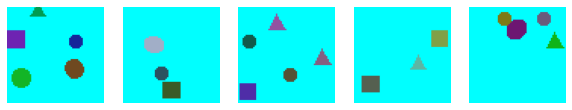

In [7]:
sample_images = generate_shape_dataset_torch(img_size=64, num_images=5)  # [5, 3, 64, 64]
print(f'sample_images: {sample_images}')
# plot
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    ax = fig.add_subplot(1, len(sample_images), i + 1)
    ax.imshow(sample_images[i][0].permute(1, 2, 0).data.cpu())
    ax.set_axis_off()

### <img src="https://img.icons8.com/external-flaticons-flat-flat-icons/64/000000/external-neural-network-the-future-flaticons-flat-flat-icons.png" style="height:50px;display:inline"> The Model
---
* The model has 3 main components: encoder network, prior network, and decoder network(s).

#### Encoder
---
<img src="https://raw.githubusercontent.com/taldatech/deep-latent-particles-web/main/assets/dlp_encoder.gif" style="height:250px">

The encoder is composed of two components:
1. **Position encoder**: outputs keypoints -- the spatial location $z_p = (x,y)$ of interesting areas, where $(x,y)$ are the coordinates of pixels.
2. **Appearance encoder**: extracts patches (or glimpses) of pre-determined size centered around $z_p$ and encodes them to latent variables $z_{\alpha}$.

In [ ]:
# PSEUDOCODE - DO NOT RUN
# posterior
enc_out = self.encode(x, return_heatmap=True, mask=mask)  # position encoder
mu, logvar, kp_heatmap, mu_features, logvar_features, obj_on, _ = enc_out
# obj_on is a transperency/presence variable, valeus between [0, 1]
# kp_heatmap is a low dimension featuer map, output of the cnn - used to extract visual features later
# mu/logvar_features = None [placeholders]
# sample
z = reparameterize(mu, logvar)
# convert [x, y] to gaussian maps (gmaps) -- will be used in the decoder
gmap_1_fg = self.to_gauss_map(z[:, :-1], self.features_dim, self.features_dim)
# convert gmaps to binary mask -- to cover up parts of the visual feature maps
fg_masks_sep = get_kp_mask_from_gmap(gmap_1_fg, threshold=self.mask_threshold, binary=True, elementwise=True).detach()
fg_masks = fg_masks_sep.sum(1, keepdim=True).clamp(0, 1)
bg_masks = 1 - fg_masks
masks_sep = torch.cat([fg_masks_sep, bg_masks], dim=1)
# extract visual features around the particles
feat_source = x if self.use_object_dec else kp_heatmap.detach()
# feat_source is the source from which we extract regions (x is the original image)
obj_enc_out = self.encode_object_features_sep(feat_source, z[:, :-1], kp_heatmap.detach(), masks_sep.detach())
mu_features, logvar_features, cropped_objects = obj_enc_out[0], obj_enc_out[1], obj_enc_out[2]
# note that the last particle is reserved for the bg and is located at (0, 0) [the center of the image]
# this is why we use z[:, :-1] when we extract features for the particles

#### Prior
---
* The prior addresses the question: what are the interesting areas in the image?
* It constrains the model such that the output of the position encoder is actually spatial positions and not just random values between $[-1, 1]$.
* We extract points-of-intereset in the image by applying spatial-Softmax (SSM) over feature maps extracted from **patches** in the image. 
* We term the set of extracted prior keypoints as keypoint proposals.
* Since we output one keypoint per patch, we may end up with a large set of keypoints, not all are informative.
* To filter out some proposal keypoints, we either randomly sample from this set or use a heuristic where we take the top-K most distant keypoints from the center of the patch.
* The reasoning behind the heuristic is that SSM is based on averaging, and contant areas in the image (e.g., a solid color patch) are not informative and SSM will result in a keypoint in the center of the patch.

In [ ]:
# PSEUDOCODE - DO NOT RUN
# prior
kp_p = self.prior(x_prior, global_kp=True)  
# global_kp = True returns the coordinates in the whole image. Otherwise, returns the local coordinates inside the patch.
kp_p = kp_p.view(x_prior.shape[0], -1, 2)  # [batch_size, n_kp_total, 2]
# filter proposals by distance to the patches' center
dist_from_center = self.prior.get_distance_from_patch_centers(kp_p, global_kp=True)
_, indices = torch.topk(dist_from_center, k=self.n_kp_prior, dim=-1, largest=True)
batch_indices = torch.arange(kp_p.shape[0]).view(-1, 1).to(kp_p.device)
kp_p = kp_p[batch_indices, indices]
# random cnn features for prior also work
kp_p = kp_p.detach()
# alternatively, just sample random kp
# kp_p = kp_p[:, torch.randperm(kp_p.shape[1])[:self.n_kp_prior]]

#### Decoder
---
<img src="https://raw.githubusercontent.com/taldatech/deep-latent-particles-web/main/assets/dlp_decoder.gif" style="height:250px">

In the decoder for the **object-based** model PointNet++ models the global regions (e.g., the background) and Gaussian maps (optionally) and a separate Glimpse decoder model the objects and their masks.

In [ ]:
# PSEUDOCODE - DO NOT RUN
# decoder
gmap_1_fg = self.to_gauss_map(z[:, :-1], self.features_dim, self.features_dim)
gmap_1_bg = 1 - gmap_1_fg.sum(1, keepdim=True).clamp(0, 1).detach()
gmap_1 = torch.cat([gmap_1_fg, gmap_1_bg], dim=1)
fg_masks_sep = get_kp_mask_from_gmap(gmap_1_fg, threshold=self.mask_threshold, binary=True, elementwise=True).detach()
fg_masks = fg_masks_sep.sum(1, keepdim=True).clamp(0, 1)
bg_masks = 1 - fg_masks
masks = torch.cat([fg_masks.expand_as(gmap_1_fg), bg_masks], dim=1)
gmap_2 = self.pointnet(position=z.detach(), features=torch.cat([z.detach(), z_features], dim=-1))
gmap = torch.cat([gmap_1[:, :-1], gmap_2], dim=1)
rec = self.dec(gmap)  # bg elements
# decode object and translate them to the positions of the keypoints
object_dec_out = self.decode_objects(z, z_features, obj_on, bg=rec)
dec_objects, dec_objects_trans, rec = object_dec_out

#### Putting it All Together
---
<img src="https://raw.githubusercontent.com/taldatech/deep-latent-particles-web/main/assets/dlp_arch_all.PNG" style="height:400px">

###  <img src="https://img.icons8.com/external-icongeek26-linear-colour-icongeek26/64/000000/external-shapes-graphic-design-icongeek26-linear-colour-icongeek26.png" style="height:50px;display:inline"> Training and Optimization
---
The model is optimized as a variational autoencoder (VAE) with objective of maximizing the evidence lower bound (ELBO): $$ \log p_\theta(x) \geq \mathbb{E}_{q(z|x)} \left[\log p_\theta(x|z)\right] - KL(q(z|x) \Vert p(z)) \doteq ELBO(x) $$
The ELBO is decomposed to the <i>reconstruction error</i> and a <i>KL-divergence</i> regularization term.

However, here we have two **unordered sets** (or point clouds) of position latent variables: the posterior keypoints and the keypoint proposals from the prior. Note that *the number of points in each set may also differ*.


The Chamfer distance between two sets $S_1$ and $S_2$: 
$$ d_{CH}(S_1, S_2) = \sum_{x \in S_1}\min_{y \in S_2}||x-y||_2^2 + \sum_{y \in S_2}\min_{x \in S_1}||x-y||_2^2. $$
<img src="https://raw.githubusercontent.com/taldatech/deep-latent-particles-web/main/assets/chamfer_distance.gif" style="height:300px">

Animation by <a href="https://www.youtube.com/watch?v=P4IyrsWicfs">Luke Hawkes</a>.

We propose the <b>Chamfer-KL</b>, a <i>novel modification</i> for the KL term:
$$ d_{CH-KL}(S_1, S_2) = \sum_{x \in S_1}\min_{y \in S_2}KL(x \Vert y) + \sum_{y \in S_2}\min_{x \in S_1}KL(x \Vert y). $$
Note that the Chamfer-KL is not a metric and maintains the properties of the standard KL term.

In [ ]:
def train_dlp(ds="shapes", batch_size=16, lr=5e-4, device=torch.device("cpu"), kp_activation="none",
              pad_mode='replicate', num_epochs=250, load_model=False, n_kp=8, recon_loss_type="mse",
              use_logsoftmax=False, sigma=0.1, beta_kl=1.0, beta_rec=1.0, dropout=0.0,
              dec_bone="gauss_pointnetpp", patch_size=16, topk=15, n_kp_enc=20, eval_epoch_freq=5,
              learned_feature_dim=0, n_kp_prior=100, weight_decay=0.0, kp_range=(0, 1),
              run_prefix="", mask_threshold=0.2, use_tps=False, use_pairs=False, use_object_enc=True,
              use_object_dec=False, warmup_epoch=5, iou_thresh=0.2, anchor_s=0.25, learn_order=False,
              kl_balance=0.1, exclusive_patches=False):
    """
    ds: dataset name (str)
    enc_channels: channels for the posterior CNN (takes in the whole image)
    prior_channels: channels for prior CNN (takes in patches)
    n_kp: number of kp to extract from each (!) patch
    n_kp_prior: number of kp to filter from the set of prior kp (of size n_kp x num_patches)
    n_kp_enc: number of posterior kp to be learned (this is the actual number of kp that will be learnt)
    use_logsoftmax: for spatial-softmax, set True to use log-softmax for numerical stability
    pad_mode: padding for the CNNs, 'zeros' or  'replicate' (default)
    sigma: the prior std of the KP
    dropout: dropout for the CNNs. We don't use it though...
    dec_bone: decoder backbone -- "gauss_pointnetpp_feat": Masked Model, "gauss_pointnetpp": Object Model
    patch_size: patch size for the prior KP proposals network (not to be confused with the glimpse size)
    kp_range: the range of keypoints, can be [-1, 1] (default) or [0,1]
    learned_feature_dim: the latent visual features dimensions extracted from glimpses.
    kp_activation: the type of activation to apply on the keypoints: "tanh" for kp_range [-1, 1], "sigmoid" for [0, 1]
    mask_threshold: activation threshold (>thresh -> 1, else 0) for the binary mask created from the Gaussian-maps.
    anchor_s: defines the glimpse size as a ratio of image_size (e.g., 0.25 for image_size=128 -> glimpse_size=32)
    learn_order: experimental feature to learn the order of keypoints - but it doesn't work yet.
    use_object_enc: set True to use a separate encoder to encode visual features of glimpses.
    use_object_dec: set True to use a separate decoder to decode glimpses (Object Model).
    iou_thresh: intersection-over-union threshold for non-maximal suppression (nms) to filter bounding boxes
    use_tps: set True to use a tps augmentation on the input image for datasets that support this option
    use_pairs: for CelebA dataset, set True to use a tps-augmented image for the prior.
    topk: the number top-k particles with the lowest variance (highest confidence) to filter for the plots.
    warmup_epoch: (used for the Object Model) number of epochs where only the object decoder is trained.
    recon_loss_type: tpe of pixel reconstruction loss ("mse", "vgg").
    beta_rec: coefficient for the reconstruction loss (we use 1.0).
    beta_kl: coefficient for the KL divergence term in the loss.
    kl_balance: coefficient for the balance between the ChamferKL (for the KP)
                and the standard KL (for the visual features),
                kl_loss = beta_kl * (chamfer_kl + kl_balance * kl_features)
    exclusive_patches: (mostly) enforce one particle pre object by masking up regions that were already encoded.
    """

    # load data
    if ds == "shapes":
        image_size = 64
        ch = 3
        enc_channels = [32, 64, 128]
        prior_channels = (16, 32, 64)
        print('generating random shapes dataset')
        dataset = generate_shape_dataset_torch(num_images=40_000)
        milestones = (20, 40, 80)
    else:
        raise NotImplementedError

    # save hyper-parameters
    hparams = {'ds': ds, 'batch_size': batch_size, 'lr': lr, 'kp_activation': kp_activation, 'pad_mode': pad_mode,
               'num_epochs': num_epochs, 'n_kp': n_kp, 'recon_loss_type': recon_loss_type,
               'use_logsoftmax': use_logsoftmax, 'sigma': sigma, 'beta_kl': beta_kl, 'beta_rec': beta_rec,
               'dec_bone': dec_bone, 'patch_size': patch_size, 'topk': topk, 'n_kp_enc': n_kp_enc,
               'eval_epoch_freq': eval_epoch_freq, 'learned_feature_dim': learned_feature_dim,
               'n_kp_prior': n_kp_prior, 'weight_decay': weight_decay, 'kp_range': kp_range,
               'run_prefix': run_prefix, 'mask_threshold': mask_threshold, 'use_tps': use_tps, 'use_pairs': use_pairs,
               'use_object_enc': use_object_enc, 'use_object_dec': use_object_dec, 'warmup_epoch': warmup_epoch,
               'iou_thresh': iou_thresh, 'anchor_s': anchor_s, 'learn_order': learn_order, 'kl_balance': kl_balance,
               'milestones': milestones, 'image_size': image_size, 'enc_channels': enc_channels,
               'prior_channels': prior_channels, 'exclusive_patches': exclusive_patches}

    # create dataloader
    dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=0, pin_memory=True,
                            drop_last=True)
    # model
    model = KeyPointVAE(cdim=ch, enc_channels=enc_channels, prior_channels=prior_channels,
                        image_size=image_size, n_kp=n_kp, learned_feature_dim=learned_feature_dim,
                        use_logsoftmax=use_logsoftmax, pad_mode=pad_mode, sigma=sigma,
                        dropout=dropout, dec_bone=dec_bone, patch_size=patch_size, n_kp_enc=n_kp_enc,
                        n_kp_prior=n_kp_prior, kp_range=kp_range, kp_activation=kp_activation,
                        mask_threshold=mask_threshold, use_object_enc=use_object_enc,
                        exclusive_patches=exclusive_patches, use_object_dec=use_object_dec, anchor_s=anchor_s,
                        learn_order=learn_order).to(device)

    logvar_p = torch.log(torch.tensor(sigma ** 2)).to(device)  # logvar of the constant std -> for the kl
    # prepare saving location
    run_name = f'{ds}_dlp_{dec_bone}' + run_prefix
    log_dir = prepare_logdir(runname=run_name, src_dir='./')
    fig_dir = os.path.join(log_dir, 'figures')
    save_dir = os.path.join(log_dir, 'saves')
    save_config(log_dir, hparams)

    kl_loss_func = ChamferLossKL(use_reverse_kl=False)
    if recon_loss_type == "vgg":
        recon_loss_func = VGGDistance(device=device)
    else:
    recon_loss_func = calc_reconstruction_loss
    betas = (0.9, 0.999)
    eps = 1e-4
    # we use separate optimizers for the encoder and decoder, but it is not really necessary...
    optimizer_e = optim.Adam(model.get_parameters(encoder=True, prior=True, decoder=False), lr=lr, betas=betas, eps=eps,
                             weight_decay=weight_decay)
    optimizer_d = optim.Adam(model.get_parameters(encoder=False, prior=False, decoder=True), lr=lr, betas=betas,
                             eps=eps, weight_decay=weight_decay)

    scheduler_e = optim.lr_scheduler.MultiStepLR(optimizer_e, milestones=milestones, gamma=0.5)
    scheduler_d = optim.lr_scheduler.MultiStepLR(optimizer_d, milestones=milestones, gamma=0.5)

    if load_model:
        try:
            model.load_state_dict(
                torch.load(os.path.join(save_dir, f'{ds}_dlp_{dec_bone}.pth'), map_location=device))
            print("loaded model from checkpoint")
        except:
            print("model checkpoint not found")

    # statistics
    losses = []
    losses_rec = []
    losses_kl = []
    losses_kl_kp = []
    losses_kl_feat = []

    # save PSNR values of the reconstruction
    psnrs = []

    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        batch_losses_rec = []
        batch_losses_kl = []
        batch_losses_kl_kp = []
        batch_losses_kl_feat = []
        batch_psnrs = []
        pbar = tqdm(iterable=dataloader)
        for batch in pbar:
            if ds == 'shapes':
                x = batch[0].to(device)
                x_prior = x
            else:
                x = batch.to(device)
                x_prior = x
            batch_size = x.shape[0]
            # forward pass
            noisy_masks = (epoch < 5 * warmup_epoch)  # add small noise to the alpha masks
            model_output = model(x, x_prior=x_prior, warmup=(epoch < warmup_epoch), noisy_masks=noisy_masks)
            mu_p = model_output['kp_p']
            gmap = model_output['gmap']
            mu = model_output['mu']
            logvar = model_output['logvar']
            rec_x = model_output['rec']
            mu_features = model_output['mu_features']
            logvar_features = model_output['logvar_features']
            # object stuff
            dec_objects_original = model_output['dec_objects_original']
            cropped_objects_original = model_output['cropped_objects_original']
            obj_on = model_output['obj_on']  # [batch_size, n_kp]

            # reconstruction error
            if use_object_dec and dec_objects_original is not None and epoch < warmup_epoch:
                # reconstruct patches in the warmup stage
                if recon_loss_type == "vgg":
                    _, dec_objects_rgb = torch.split(dec_objects_original, [1, 3], dim=2)
                    dec_objects_rgb = dec_objects_rgb.reshape(-1, *dec_objects_rgb.shape[2:])
                    cropped_objects_original = cropped_objects_original.reshape(-1,
                                                                                *cropped_objects_original.shape[2:])
                    # vgg has a minimal input size, so we interpolate if the patch is too small
                    if cropped_objects_original.shape[-1] < 32:
                        cropped_objects_original = F.interpolate(cropped_objects_original, size=32, mode='bilinear',
                                                                 align_corners=False)
                        dec_objects_rgb = F.interpolate(dec_objects_rgb, size=32, mode='bilinear',
                                                        align_corners=False)
                    loss_rec_obj = recon_loss_func(cropped_objects_original, dec_objects_rgb, reduction="mean")

                else:
                    _, dec_objects_rgb = torch.split(dec_objects_original, [1, 3], dim=2)
                    dec_objects_rgb = dec_objects_rgb.reshape(-1, *dec_objects_rgb.shape[2:])
                    cropped_objects_original = cropped_objects_original.clone().reshape(-1,
                                                                                        *cropped_objects_original.shape[
                                                                                         2:])
                    loss_rec_obj = calc_reconstruction_loss(cropped_objects_original, dec_objects_rgb,
                                                            loss_type='mse', reduction='mean')
                loss_rec = loss_rec_obj
            else:
                # reconstruct full image
                if recon_loss_type == "vgg":
                    loss_rec = recon_loss_func(x, rec_x, reduction="mean")
                else:
                    loss_rec = calc_reconstruction_loss(x, rec_x, loss_type='mse', reduction='mean')

                with torch.no_grad():
                    psnr = -10 * torch.log10(F.mse_loss(rec_x, x))
                    batch_psnrs.append(psnr.data.cpu().item())

            # kl-divergence
            logvar_kp = logvar_p.expand_as(mu_p)

            # the final kp is the bg kp which is located in the center (so no need for it)
            # to reproduce the results on celeba, use `mu_post = mu`, `logvar_post = logvar`
            mu_post = mu[:, :-1]
            logvar_post = logvar[:, :-1]
            # mu_post = mu
            # logvar_post = logvar
            mu_prior = mu_p
            logvar_prior = logvar_kp

            loss_kl_kp = kl_loss_func(mu_preds=mu_post, logvar_preds=logvar_post, mu_gts=mu_prior,
                                      logvar_gts=logvar_prior).mean()

            if learned_feature_dim > 0:
                loss_kl_feat = calc_kl(logvar_features.view(-1, logvar_features.shape[-1]),
                                       mu_features.view(-1, mu_features.shape[-1]), reduce='none')
                loss_kl_feat = loss_kl_feat.view(batch_size, n_kp_enc + 1).sum(1).mean()
            else:
                loss_kl_feat = torch.tensor(0.0, device=device)
            loss_kl = loss_kl_kp + kl_balance * loss_kl_feat

            loss = beta_rec * loss_rec + beta_kl * loss_kl
            # backprop
            optimizer_e.zero_grad()
            optimizer_d.zero_grad()
            loss.backward()
            optimizer_e.step()
            optimizer_d.step()
            # log
            batch_losses.append(loss.data.cpu().item())
            batch_losses_rec.append(loss_rec.data.cpu().item())
            batch_losses_kl.append(loss_kl.data.cpu().item())
            batch_losses_kl_kp.append(loss_kl_kp.data.cpu().item())
            batch_losses_kl_feat.append(loss_kl_feat.data.cpu().item())
            # progress bar
            if use_object_dec and epoch < warmup_epoch:
                pbar.set_description_str(f'epoch #{epoch} (warmup)')
            elif use_object_dec and noisy_masks:
                pbar.set_description_str(f'epoch #{epoch} (noisy masks)')
            else:
                pbar.set_description_str(f'epoch #{epoch}')
            pbar.set_postfix(loss=loss.data.cpu().item(), rec=loss_rec.data.cpu().item(),
                             kl=loss_kl.data.cpu().item())
        pbar.close()
        losses.append(np.mean(batch_losses))
        losses_rec.append(np.mean(batch_losses_rec))
        losses_kl.append(np.mean(batch_losses_kl))
        losses_kl_kp.append(np.mean(batch_losses_kl_kp))
        losses_kl_feat.append(np.mean(batch_losses_kl_feat))
        if len(batch_psnrs) > 0:
            psnrs.append(np.mean(batch_psnrs))
        # keep track of bounding box scores to set a hard threshold (as bb scores are not normalized)
        # epoch_bb_scores = torch.cat(batch_bb_scores, dim=0)
        # bb_mean_score = epoch_bb_scores.mean().data.cpu().item()
        # bb_mean_scores.append(bb_mean_score)
        # schedulers
        scheduler_e.step()
        scheduler_d.step()
        # epoch summary
        log_str = f'epoch {epoch} summary for dec backbone: {dec_bone}\n'
        log_str += f'loss: {losses[-1]:.3f}, rec: {losses_rec[-1]:.3f}, kl: {losses_kl[-1]:.3f}\n'
        log_str += f'kl_balance: {kl_balance:.4f}, kl_kp: {losses_kl_kp[-1]:.3f}, kl_feat: {losses_kl_feat[-1]:.3f}\n'
        log_str += f'mu max: {mu.max()}, mu min: {mu.min()}\n'
        if ds != 'celeba':
            log_str += f'val loss (freq: {eval_epoch_freq}): {valid_loss:.3f},' \
                       f' best: {best_valid_loss:.3f} @ epoch: {best_valid_epoch}\n'
        if obj_on is not None:
            log_str += f'obj_on max: {obj_on.max()}, obj_on min: {obj_on.min()}\n'
        if len(psnrs) > 0:
            log_str += f'mean psnr: {psnrs[-1]:.3f}\n'
        print(log_str)
        log_line(log_dir, log_str)

        if epoch % eval_epoch_freq == 0 or epoch == num_epochs - 1:
            max_imgs = 8
            img_with_kp = plot_keypoints_on_image_batch(mu[:, :-1].clamp(min=kp_range[0], max=kp_range[1]), x, radius=3,
                                                        thickness=1, max_imgs=max_imgs, kp_range=kp_range)
            img_with_kp_p = plot_keypoints_on_image_batch(mu_p, x_prior, radius=3, thickness=1, max_imgs=max_imgs,
                                                          kp_range=kp_range)
            # top-k
            with torch.no_grad():
                logvar_sum = logvar[:, :-1].sum(-1)
                logvar_topk = torch.topk(logvar_sum, k=topk, dim=-1, largest=False)
                indices = logvar_topk[1]  # [batch_size, topk]
                batch_indices = torch.arange(mu.shape[0]).view(-1, 1).to(mu.device)
                topk_kp = mu[batch_indices, indices]
                # bounding boxes
                masks = create_masks_fast(mu[:, :-1].detach(), anchor_s=model.anchor_s, feature_dim=x.shape[-1])
                masks = torch.where(masks < mask_threshold, 0.0, 1.0)
                bb_scores = -1 * logvar_sum
                hard_threshold = bb_scores.mean()
            if use_object_dec:
                img_with_masks_nms, nms_ind = plot_bb_on_image_batch_from_masks_nms(masks, x, scores=bb_scores,
                                                                                    iou_thresh=iou_thresh,
                                                                                    thickness=1, max_imgs=max_imgs,
                                                                                    hard_thresh=hard_threshold)
                # hard_thresh: a general threshold for bb scores (set None to not use it)
                bb_str = f'bb scores: max: {bb_scores.max():.2f}, min: {bb_scores.min():.2f},' \
                         f' mean: {bb_scores.mean():.2f}\n'
                print(bb_str)
            log_line(log_dir, bb_str)
            img_with_kp_topk = plot_keypoints_on_image_batch(topk_kp.clamp(min=kp_range[0], max=kp_range[1]), x,
                                                             radius=3, thickness=1, max_imgs=max_imgs,
                                                             kp_range=kp_range)
            if use_object_dec and dec_objects_original is not None:
                dec_objects = model_output['dec_objects']
                vutils.save_image(torch.cat([x[:max_imgs, -3:], img_with_kp[:max_imgs, -3:].to(device),
                                             rec_x[:max_imgs, -3:], img_with_kp_p[:max_imgs, -3:].to(device),
                                             img_with_kp_topk[:max_imgs, -3:].to(device),
                                             dec_objects[:max_imgs, -3:],
                                             img_with_masks_nms[:max_imgs, -3:].to(device)],
                                            dim=0).data.cpu(), '{}/image_{}.jpg'.format(fig_dir, epoch),
                                  nrow=8, pad_value=1)
                with torch.no_grad():
                    _, dec_objects_rgb = torch.split(dec_objects_original, [1, 3], dim=2)
                    dec_objects_rgb = dec_objects_rgb.reshape(-1, *dec_objects_rgb.shape[2:])
                    cropped_objects_original = cropped_objects_original.clone().reshape(-1, 3,
                                                                                        cropped_objects_original.shape[
                                                                                            -1],
                                                                                        cropped_objects_original.shape[
                                                                                            -1])
                    if cropped_objects_original.shape[-1] != dec_objects_rgb.shape[-1]:
                        cropped_objects_original = F.interpolate(cropped_objects_original,
                                                                 size=dec_objects_rgb.shape[-1],
                                                                 align_corners=False, mode='bilinear')
                vutils.save_image(
                    torch.cat([cropped_objects_original[:max_imgs * 2, -3:], dec_objects_rgb[:max_imgs * 2, -3:]],
                              dim=0).data.cpu(), '{}/image_obj_{}.jpg'.format(fig_dir, epoch),
                    nrow=8, pad_value=1)
            else:
                vutils.save_image(torch.cat([x[:max_imgs, -3:], img_with_kp[:max_imgs, -3:].to(device),
                                             rec_x[:max_imgs, -3:], img_with_kp_p[:max_imgs, -3:].to(device),
                                             img_with_kp_topk[:max_imgs, -3:].to(device)],
                                            dim=0).data.cpu(), '{}/image_{}.jpg'.format(fig_dir, epoch),
                                  nrow=8, pad_value=1)
            torch.save(model.state_dict(),
                       os.path.join(save_dir, f'{ds}_dlp_{dec_bone}{run_prefix}.pth'))
        # plot graphs
        if epoch > 0:
            num_plots = 3
            fig = plt.figure()
            ax = fig.add_subplot(num_plots, 1, 1)
            ax.plot(np.arange(len(losses[1:])), losses[1:], label="loss")
            ax.set_title(run_name)
            ax.legend()

            ax = fig.add_subplot(num_plots, 1, 2)
            ax.plot(np.arange(len(losses_kl[1:])), losses_kl[1:], label="kl", color='red')
            if learned_feature_dim > 0:
                ax.plot(np.arange(len(losses_kl_kp[1:])), losses_kl_kp[1:], label="kl_kp", color='cyan')
                ax.plot(np.arange(len(losses_kl_feat[1:])), losses_kl_feat[1:], label="kl_feat", color='green')
            ax.legend()

            ax = fig.add_subplot(num_plots, 1, 3)
            ax.plot(np.arange(len(losses_rec[1:])), losses_rec[1:], label="rec", color='green')
            ax.legend()
            plt.tight_layout()
            plt.savefig(f'{fig_dir}/{run_name}_graph.jpg')
            plt.close('all')
    return model

In [ ]:
# training
# default hyper-parameters
lr = 1e-3
batch_size = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 100
load_model = False
eval_epoch_freq = 2
n_kp = 1  # num kp per patch
mask_threshold = 0.2  # mask threshold for the features from the encoder
kp_range = (-1, 1)
weight_decay = 0.0
run_prefix = ""
learn_order = False
use_logsoftmax = False
pad_mode = 'replicate'
sigma = 0.1  # default sigma for the gaussian maps
dropout = 0.0
kp_activation = "tanh"
# ds specific hp
ds = "shapes"
beta_kl = 0.05
beta_rec = 1.0
n_kp_enc = 10  # total kp to output from the encoder / filter from prior
n_kp_prior = 15
patch_size = 8
learned_feature_dim = 6  # additional features than x,y for each kp
dec_bone = "gauss_pointnetpp"
topk = min(10, n_kp_enc)  # display top-10 kp with smallest variance
recon_loss_type = "mse"
use_tps = False
use_pairs = False
use_object_enc = True  # separate object encoder
use_object_dec = True  # separate object decoder
warmup_epoch = 1
anchor_s = 0.25
kl_balance = 0.001
exclusive_patches = True

model = train_dlp(ds=ds, batch_size=batch_size, lr=lr,
                      device=device, num_epochs=num_epochs, kp_activation=kp_activation,
                      load_model=load_model, n_kp=n_kp, use_logsoftmax=use_logsoftmax, pad_mode=pad_mode,
                      sigma=sigma, beta_kl=beta_kl, beta_rec=beta_rec, dropout=dropout, dec_bone=dec_bone,
                      kp_range=kp_range, learned_feature_dim=learned_feature_dim, weight_decay=weight_decay,
                      recon_loss_type=recon_loss_type, patch_size=patch_size, topk=topk, n_kp_enc=n_kp_enc,
                      eval_epoch_freq=eval_epoch_freq, n_kp_prior=n_kp_prior, run_prefix=run_prefix,
                      mask_threshold=mask_threshold, use_tps=use_tps, use_pairs=use_pairs, anchor_s=anchor_s,
                      use_object_enc=use_object_enc, use_object_dec=use_object_dec, exclusive_patches=exclusive_patches,
                      warmup_epoch=warmup_epoch, learn_order=learn_order, kl_balance=kl_balance)

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com